# Section 0 - Requirements and helper functions

In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib import Graph, Literal, Namespace, RDFS
from csv import DictReader
from owlready2 import get_ontology, sync_reasoner_pellet

from pyspark.sql import SparkSession
from pyspark import SparkConf, find_spark_home
print(find_spark_home._find_spark_home())


C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\pyspark


In [2]:
def camelCase(text):
    return text.title().replace(" ", "")

# Section 1 - Ontology population

In this section the knowledge graph is created by populating the empty ontology with instances and creating their relationships.

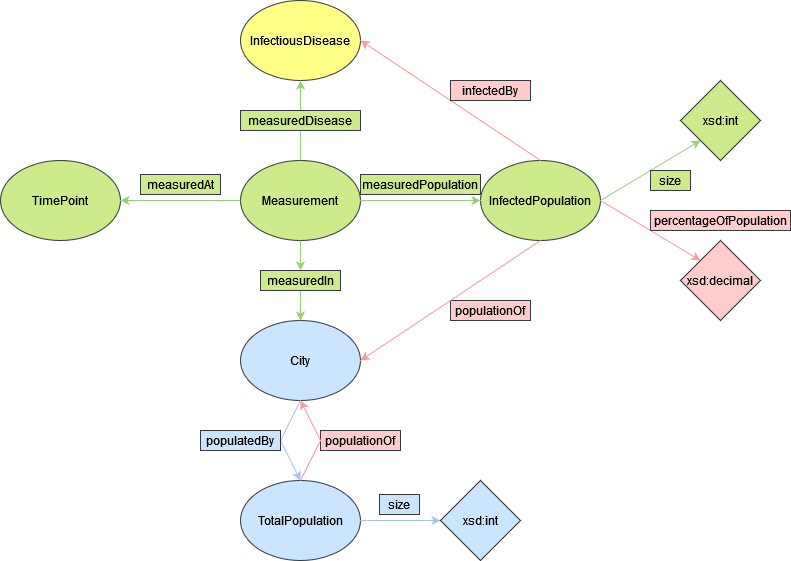
  
The yellow part is specified in the constant DISEASE_NAME in the cell below  
The blue parts of this graph are created in Subsection 1.1 - Cities and Population  
The green parts of this graph are created in Subsection 1.2 - Measurements  
The red parts of this graph are created in Subsection 1.4 - Pellet Reasoner  

In [3]:
graph = Graph()
with open("epi-blank.ttl", "r") as f:
    graph.parse(f, format="turtle")

EPI = Namespace("http://github.com/jkuwalek/vrije-KnD-final-project/ontology/")
graph.bind("epi", EPI)
XSD = Namespace("http://www.w3.org/2001/XMLSchema#")
graph.bind("xsd", XSD)

CITIES = {}
DISEASE_NAME = "Covid-19"
DISEASE_TAG = "C19"

## Subsection 1.1 - Cities and Population (Blue)


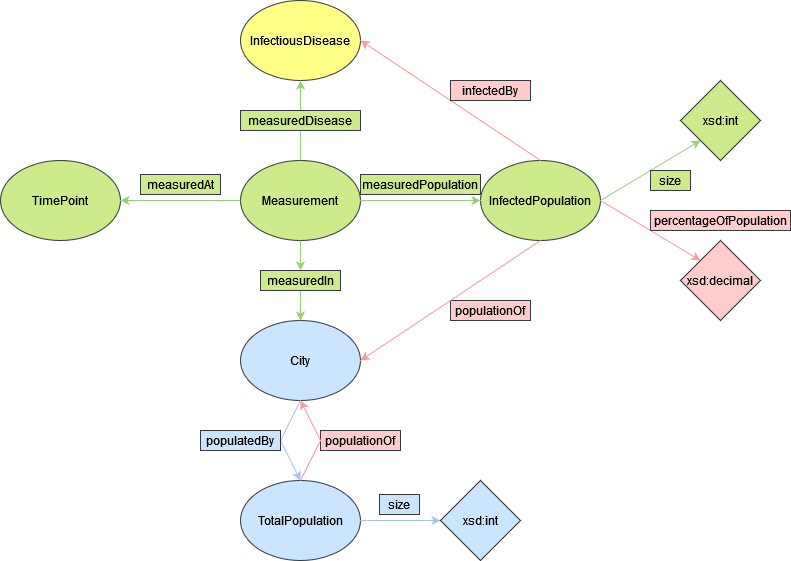

In this section the ontology is populated with dutch graph and their respective populations.


In [4]:
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

sparql.setReturnFormat(JSON)


# gets the first 3 geological ages

# from a Geological Timescale database,

# via a SPARQL endpoint

sparql.setQuery(
    """
    SELECT DISTINCT ?city ?cityLabel_nl ?cityLabel_en ?population WHERE {
    ?city wdt:P31 wd:Q515 . # instance of city
    ?city wdt:P17 wd:Q55 . # country Netherlands
    ?city wdt:P1082 ?population .
    ?city rdfs:label ?cityLabel_en.
    ?city rdfs:label ?cityLabel_nl.

    FILTER(LANG(?cityLabel_en) = "en")
    FILTER(LANG(?cityLabel_nl) = "nl")
}
    """
)

try:
    ret = sparql.queryAndConvert()
    if not isinstance(ret, dict):
        raise Exception("not isinstance(ret, dict)")

    for city in ret["results"]["bindings"]:
        CITIES[camelCase(city["cityLabel_nl"]["value"])] = [city["population"]["value"], city["cityLabel_nl"]["value"], city["cityLabel_en"]["value"]]

    for city_name, (population, label_nl, label_en) in CITIES.items():
        city_uri = EPI[city_name]
        population_uri = EPI[f"PopulationOf{ city_name }"]
        # Data Properties
        graph.add((city_uri, EPI.populatedBy, population_uri))
        graph.add(
            (
                population_uri,
                EPI.size,
                Literal(
                    population,
                    datatype=XSD["int"],
                ),
            )
        )

        # Labels
        graph.add(
            (city_uri, RDFS.label, Literal(label_nl, lang="nl"))
        )
        graph.add(
            (city_uri, RDFS.label, Literal(label_en, lang="en"))
        )
        graph.add(
            (
                population_uri,
                RDFS.label,
                Literal(f"Population of {label_nl}", lang="nl"),
            )
        )
        graph.add(
            (
                population_uri,
                RDFS.label,
                Literal(f"Population of {label_en}", lang="en"),
            )
        )
except Exception as e:
    print(e)
else:
    print("Success!")

Success!


## Subsection 1.2 - Measurements (Green)

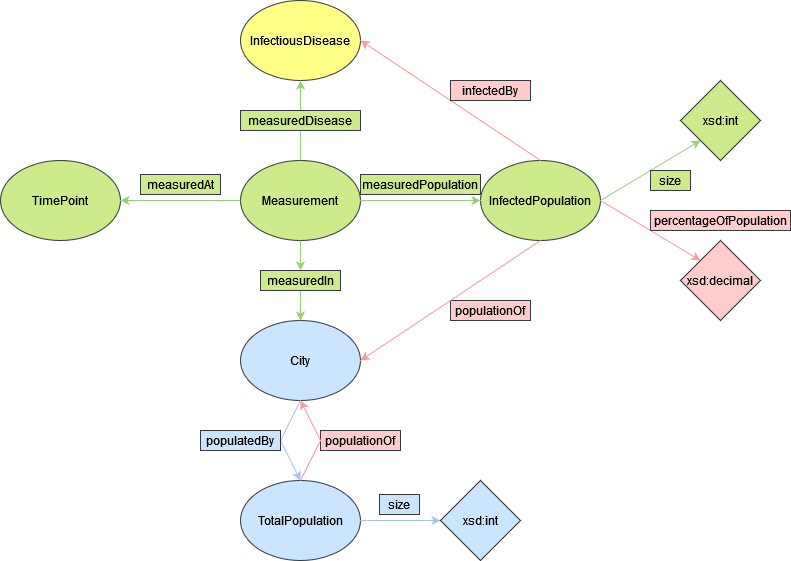

In [5]:
measurements = {}
with open("COVID-19_aantallen_gemeente_per_dag.csv") as f:
    data = DictReader(f, delimiter=";")
    ommited_cities = set()

    for dataPoint in data:
        city_name = camelCase(dataPoint["Municipality_name"])

        if city_name not in CITIES:
            ommited_cities.add(city_name)
            continue
        time_point = dataPoint["Date_of_publication"]

        # LIMIT TO ONLY 2 ENTRIES PER MONTH DUE TO ADVANCED SYSTEM REQUIREMENTS TO RUN THE REASONER
        if not (time_point.endswith("-01") or time_point.endswith("-15")):
            continue

        # Done this way to merge measurements of diffrent ROAZ_region (same municipality)
        measurements[city_name] = measurements.get(city_name, {})
        measurements[city_name][time_point] = city.get(time_point, 0) + int(dataPoint["Total_reported"])

for city_name, data in measurements.items():
    for time_point, total_infected in data.items():
        city_uri = EPI[city_name]
        measurement_uri = EPI["M" + DISEASE_TAG + city_name + time_point]
        infected_population_uri = EPI["IP" + DISEASE_TAG + city_name + time_point]
        time_point_uri = EPI[time_point]

        graph.add((measurement_uri, EPI.measuredIn, city_uri))
        graph.add((measurement_uri, EPI.measuredPopulation, infected_population_uri))
        graph.add(
            (infected_population_uri, EPI.size, Literal(total_infected, datatype=XSD["int"]))
        )
        graph.add((measurement_uri, EPI.measuredAt, time_point_uri))
        graph.add((measurement_uri, EPI.measuredDisease, EPI[DISEASE_NAME]))


print("Success!")
# print("The following cities have not been included in the knowledge graph:", "\n".join(ommited_cities))

Success!


## Section 1.3 - Exporting explicit triples

In [6]:
try:
    graph.serialize(destination="epi.owl", format="xml")
except Exception as e:
    print(e)
else:
    print("Success!")

Success!


## Subsection 1.4 - Pellet reasoner (Red)

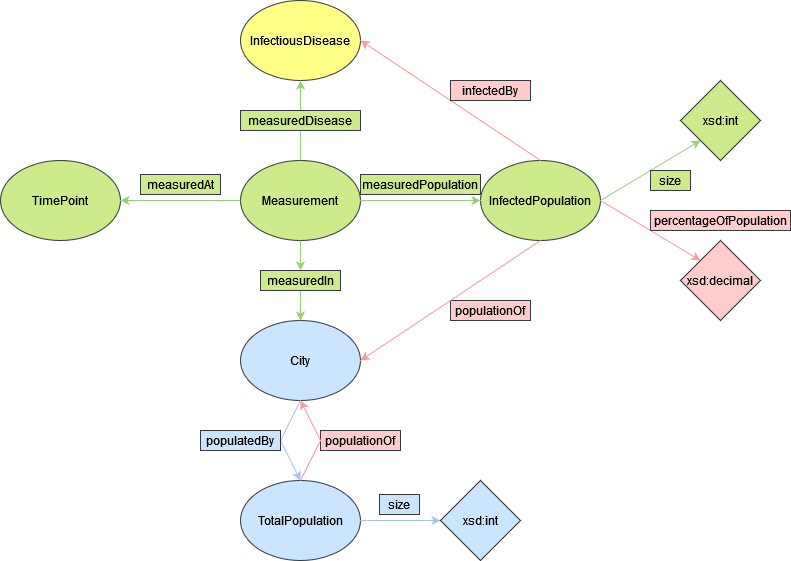

In [7]:
import os
os.environ["JAVA_TOOL_OPTIONS"] = "-Xmx16G -XX:+UseG1GC -XX:+PrintGCDetails"


epi = get_ontology("epi.owl").load()

with epi:

    sync_reasoner_pellet(infer_property_values=True, infer_data_property_values=True)

    # owlready2 is only capable of storing the data in xml format,

    # therefore we store it as xml and then convert to ttl too

    epi.save(file="epi_with_inferrences.owl", format="rdfxml")


e = Graph()

e.parse("epi_with_inferrences.owl", format="xml")

e.serialize(destination="epi_with_inferrences.ttl", format="ttl")


print("Success!")

* Owlready2 * Running Pellet...
    java -Xmx2000M -cp C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\antlr-3.2.jar;C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\antlr-runtime-3.2.jar;C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\aterm-java-1.6.jar;C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\commons-codec-1.6.jar;C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\httpclient-4.2.3.jar;C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\httpcore-4.2.2.jar;C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\jcl-over-slf4j-1.6.4.jar;C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\jena-arq-2.10.0.jar;C:\Users\matus\AppData\Roaming\Python\Python312\site-packages\owlready2\pellet\jena-core-2.10.0.jar;C:\Users\matus\AppData\Roaming\Python\Python312\sit

Success!
